In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [33]:
# Generate toy data: two one-dimensional exponential distributions
np.random.seed(42)
N_0, N_1 = 10000, 10000
lambda_0, lambda_1 = 1.0, 0.5

z_0 = np.random.exponential(scale=1 / lambda_0, size=N_0).reshape(-1, 1).astype(np.float32)
w_0 = np.ones(N_0, dtype=np.float32)  # Equal weights for simplicity

z_1 = np.random.exponential(scale=1 / lambda_1, size=N_1).reshape(-1, 1).astype(np.float32)
w_1 = np.ones(N_1,dtype=np.float32)

In [34]:
print(z_0)

[[0.46926808]
 [3.0101213 ]
 [1.3167456 ]
 ...
 [2.9319675 ]
 [0.5066477 ]
 [0.24480191]]


In [35]:
# Combine the datasets and labels
z = np.concatenate([z_0, z_1], axis=0)
w = np.concatenate([w_0, w_1], axis=0)
y = np.concatenate([np.zeros(N_0), np.ones(N_1)]).astype(np.float32)

In [36]:
print(z)

[[0.46926808]
 [3.0101213 ]
 [1.3167456 ]
 ...
 [0.72394496]
 [1.1715294 ]
 [0.378124  ]]


In [37]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((z, y, w)).shuffle(len(z)).batch(128)

In [38]:
# Define the neural network model
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [39]:
# Define custom loss function
def custom_loss(y_true, y_pred, weights):
    term_1 = tf.reduce_sum(weights * y_true * -tf.math.log(y_pred + 1e-8))
    term_0 = tf.reduce_sum(weights * (1 - y_true) * -tf.math.log(1 - y_pred + 1e-8))
    return term_1 + term_0

In [40]:
# Training step
@tf.function
def train_step(x, y, weights):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = custom_loss(y, predictions, weights)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [41]:
# Compute r(z)
def compute_r(z):
    f_z = model.predict(z)
    return f_z / (1 - f_z + 1e-8)

In [42]:
# Initialize the model
input_dim = z.shape[1]
model = create_model(input_dim)

In [43]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [44]:
# Training loop
epochs = 50
for epoch in range(epochs):
    epoch_loss = 0
    for x_batch, y_batch, w_batch in dataset:
        loss = train_step(x_batch, tf.expand_dims(y_batch, axis=-1), w_batch)
        epoch_loss += loss.numpy()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

2025-03-13 16:25:49.615214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [20000]
	 [[{{node Placeholder/_2}}]]
2025-03-13 16:25:49.615424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [20000]
	 [[{{node Placeholder/_2}}]]


Epoch 1, Loss: 1639680.3749
Epoch 2, Loss: 1622084.2607
Epoch 3, Loss: 1621226.6052
Epoch 4, Loss: 1621499.4312
Epoch 5, Loss: 1621134.5606
Epoch 6, Loss: 1622246.6923
Epoch 7, Loss: 1621609.7096
Epoch 8, Loss: 1620668.0496
Epoch 9, Loss: 1621557.9016
Epoch 10, Loss: 1621315.2904
Epoch 11, Loss: 1621180.8182
Epoch 12, Loss: 1621813.7834
Epoch 13, Loss: 1620690.7336
Epoch 14, Loss: 1621880.6473
Epoch 15, Loss: 1621419.4611
Epoch 16, Loss: 1620632.8757
Epoch 17, Loss: 1620486.4841
Epoch 18, Loss: 1620504.5781
Epoch 19, Loss: 1621579.4025
Epoch 20, Loss: 1621035.2808
Epoch 21, Loss: 1620687.7234
Epoch 22, Loss: 1621718.8098
Epoch 23, Loss: 1621459.9614
Epoch 24, Loss: 1621126.1512
Epoch 25, Loss: 1621407.0286
Epoch 26, Loss: 1620833.4703
Epoch 27, Loss: 1620380.8639
Epoch 28, Loss: 1621714.4978
Epoch 29, Loss: 1620458.4970
Epoch 30, Loss: 1620910.5924
Epoch 31, Loss: 1620404.6653
Epoch 32, Loss: 1620826.9969
Epoch 33, Loss: 1621056.8049
Epoch 34, Loss: 1620858.7193
Epoch 35, Loss: 1621659

In [45]:
r_z_0 = compute_r(z_0)
r_z_1 = compute_r(z_1)

313/313 [==============================] - 0s 380us/step


In [46]:
# Reweighting and closure test
weights_0_to_1 = w_0 * r_z_0.flatten()
weights_1_to_0 = w_1 / (r_z_1.flatten() + 1e-8)

In [47]:
# Make histograms
bins = np.linspace(0, np.max([z_0.max(), z_1.max()]), 50)
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

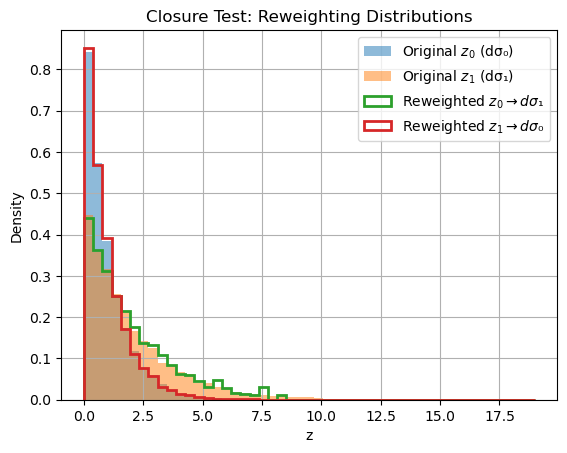

In [48]:
# Original distributions
plt.hist(z_0, bins=bins, weights=w_0, alpha=0.5, label="Original $z_0$ (dσ₀)", density=True)
plt.hist(z_1, bins=bins, weights=w_1, alpha=0.5, label="Original $z_1$ (dσ₁)", density=True)

# Reweighted distributions
plt.hist(z_0, bins=bins, weights=weights_0_to_1, histtype='step', lw=2, label="Reweighted $z_0 \\to dσ₁$", density=True)
plt.hist(z_1, bins=bins, weights=weights_1_to_0, histtype='step', lw=2, label="Reweighted $z_1 \\to dσ₀$", density=True)

# Plot settings
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.title("Closure Test: Reweighting Distributions")
plt.grid()
plt.show()

# plt.savefig("closure_test.png")